Epoch [100/100]: 100%|██████████| 12/12 [00:01<00:00,  8.68it/s, loss=0.0218]


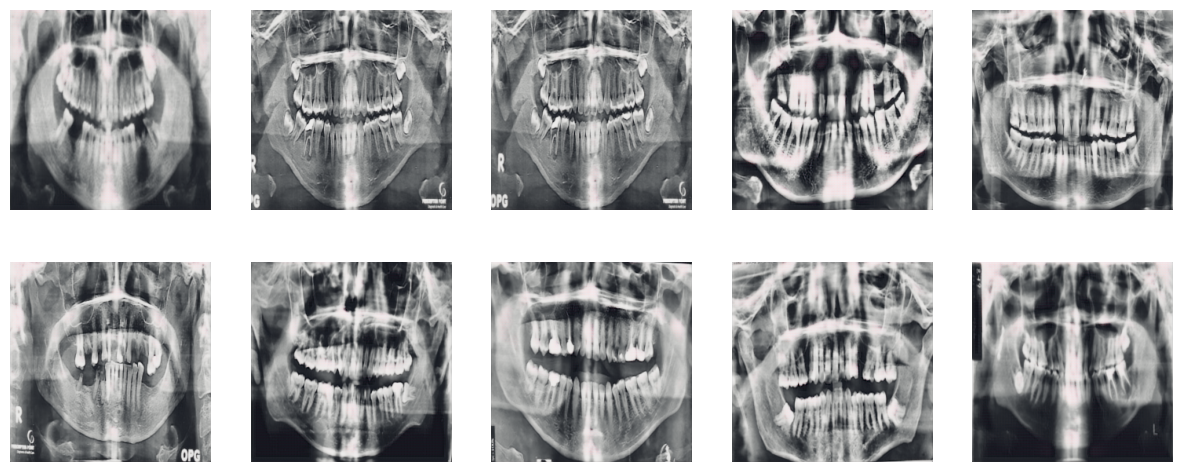

ZIP file created: images.zip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import shutil

# Define  UNet Generator with noise injection
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(2, 2)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.final = nn.Conv2d(64, 3, 3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, noise):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))  

        
        noise = noise.view(noise.size(0), 256, 1, 1)  
        noise = F.interpolate(noise, size=(e3.shape[2], e3.shape[3]), mode='bilinear', align_corners=False)
        e3 = e3 + noise 

        d3 = self.up3(e3)
        d3 = torch.cat((d3, e2), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e1), dim=1)
        d2 = self.dec2(d2)

        return self.tanh(self.final(d2))

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, "*.png")) + glob.glob(os.path.join(image_dir, "*.jpg"))
        if not self.image_paths:
            raise FileNotFoundError(f"No images found in {image_dir}. Check the path.")
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        if self.transform:
            image = self.transform(image)
        return image, 0  

# Load Dataset
data_dir = "/kaggle/input/generated-dental-dataset/Dental OPG (Classification)/Infection"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
dataset = CustomImageDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator().to(device)
optimizer = optim.Adam(generator.parameters(), lr=0.005)
criterion = nn.L1Loss()

# Training Loop
def train_model(generator, dataloader, epochs=100):
    generator.train()
    for epoch in range(epochs):
        loop = tqdm(dataloader, leave=True)
        for real_images, _ in loop:
            real_images = real_images.to(device)

            # Generate random noise
            noise = torch.randn(real_images.size(0), 256, 1, 1).to(device)

            optimizer.zero_grad()
            fake_images = generator(real_images, noise)
            loss = criterion(fake_images, real_images)  # Use L1 loss

            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

# Train Model
train_model(generator, dataloader, epochs=100)


generator.eval()
os.makedirs("images", exist_ok=True)
with torch.no_grad():
    for i in range(46):
        sample_image, _ = dataset[i]
        sample_image = sample_image.unsqueeze(0).to(device)
        noise = torch.randn(1, 256, 1, 1).to(device)
        output_image = generator(sample_image, noise)
        save_image(output_image, f"images/image{i}.png")

# Show Generated Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = plt.imread(f"images/image{i}.png")
    ax.imshow(img)
    ax.axis("off")
plt.show()

# Zip the generated images
shutil.make_archive("/kaggle/working/images", 'zip', "images")

print("ZIP file created: images.zip")
